# Initialization

## Import Packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
import arff
from tqdm import tqdm
import pixiedust

from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB

import copy
from scipy import stats

import seaborn as sns; sns.set()
import pandas as pd

from skmultiflow.bayes.naive_bayes import NaiveBayes
from sklearn.preprocessing import OneHotEncoder

Pixiedust database opened successfully


## Loading .arff Dataset

In [2]:
def load_arff(path, dataset_name, num_copy):
    if num_copy == -1:
        file_path = path + dataset_name + '/' + dataset_name + '.arff'
        dataset = arff.load(open(file_path), encode_nominal=True)
    else:
        file_path = path + dataset_name + '/' + dataset_name + str(
            num_copy) + '.arff'
        dataset = arff.load(open(file_path), encode_nominal=True)
    np_data = np.array(dataset["data"])    
    return np_data

# Fast Switch NB

In [3]:
class fsNB(object):
    def __init__(self,
                 fix_size=50,
                 eval_size=100,
                 alpha=0.2,
                 num_shuffle=10,
                 num_finetuned_residual=50):

        self.retrained_model = NaiveBayes()
        self.finetuned_model = NaiveBayes()
        self.buffered_X = None
        self.buffered_Y = None
        self.retrained_resid = None
        self.finetuned_resid = None
        self.fix_size = fix_size
        self.eva_size = eval_size
        self.alpha = alpha
        self.num_shuffle = num_shuffle
        self.num_finetuned_residual = num_finetuned_residual

    def fit(self, X, Y):

        self.buffered_X = X
        self.buffered_Y = Y
        self.finetuned_model = NaiveBayes()
        self.finetuned_model.fit(X, Y)

        if self.buffered_X.shape[0] >= self.fix_size + self.eva_size:

            temp_resid = None
            for i in range(self.num_shuffle):

                shuffle_idx = np.random.permutation(X.shape[0])

                trai_idx, test_idx = shuffle_idx[:self.fix_size], shuffle_idx[
                    -self.eva_size:]
                temp_model = NaiveBayes()
                temp_model.fit(X[trai_idx], Y[trai_idx])
                if temp_resid is None:
                    temp_resid = Y[test_idx] - temp_model.predict_proba(
                        X[test_idx])[np.arange(test_idx.shape[0]), Y[test_idx].
                                     astype(int)]
                else:
                    temp_resid = np.hstack([
                        temp_resid,
                        Y[test_idx] - temp_model.predict_proba(X[test_idx])
                        [np.arange(test_idx.shape[0]), Y[test_idx].astype(int)]
                    ])
                #if np.sum(np.abs(temp_resid)) < min_resid:
                #min_resid = np.sum(np.abs(temp_resid))
                #self.retrained_model = temp_model
            self.retrained_resid = copy.deepcopy(temp_resid)
            shuffle_idx = np.random.permutation(
                temp_resid.shape[0])[:self.num_finetuned_residual]
            self.finetuned_resid = temp_resid[shuffle_idx]

    def partial_fit(self, new_X, new_Y):

        self.buffered_X = np.vstack([self.buffered_X, new_X])
        self.buffered_Y = np.hstack([self.buffered_Y, new_Y])

        if self.buffered_X.shape[0] >= self.fix_size + self.eva_size:
            if self.retrained_resid is None:
                self.fit(self.buffered_X, self.buffered_Y)
            else:
                self.buffered_X = self.buffered_X[-(self.fix_size +
                                                    self.eva_size):]
                self.buffered_Y = self.buffered_Y[-(self.fix_size +
                                                    self.eva_size):]
                temp_resid = new_Y - self.finetuned_model.predict_proba(
                    new_X)[np.arange(new_Y.shape[0]),
                           new_Y.astype(int)]
                self.finetuned_resid = np.hstack(
                    [self.finetuned_resid[new_X.shape[0]:], temp_resid])
                self.drift_detection()
                self.finetuned_model.partial_fit(new_X, new_Y)
        else:
            self.finetuned_model.partial_fit(new_X, new_Y)

    def predict(self, target_X):
        return self.finetuned_model.predict(target_X)

    def drift_detection(self):
        if np.mean(np.abs(self.finetuned_resid)) >= np.mean(
                np.abs(self.retrained_resid)):
            D, p = stats.ks_2samp(self.retrained_resid, self.finetuned_resid)
            #             print(p)
            if p < self.alpha:
                #                 print('   replace')
                self.fit(self.buffered_X, self.buffered_Y)

## Baseline NB

In [4]:
def BaselineNB(data, ini_size=25):
    preds = np.zeros(data.shape[0])
    ini_train_X, ini_train_Y = data[:ini_size, :-1], data[:ini_size, -1]
    clf = NaiveBayes()
    clf.fit(ini_train_X, ini_train_Y)

    for i in tqdm(range(ini_size, data.shape[0]), desc="#inst"):
        new_inst_X, new_inst_Y = data[i:i + 1, :-1], data[i:i+1, -1]
        preds[i] = clf.predict(new_inst_X)
    return preds

## Sliding NB

In [5]:
def SlideNB(data, ini_size=25, slide_size=25):

    preds = np.zeros(data.shape[0])
    ini_train_X, ini_train_Y = data[:ini_size, :-1], data[:ini_size, -1]
    clf = NaiveBayes()
    clf.fit(ini_train_X, ini_train_Y)

    for i in tqdm(range(ini_size, data.shape[0], slide_size), desc="#inst"):
        new_inst_X, new_inst_Y = data[i:i + slide_size, :-1], data[i:i+slide_size, -1]
        preds[i:i + slide_size] = clf.predict(new_inst_X)
        clf = NaiveBayes()
        clf.fit(new_inst_X, new_inst_Y)
    return preds

## Incremental NB

In [6]:
def IncNB(data, ini_size=25):

    preds = np.zeros(data.shape[0])
    ini_train_X, ini_train_Y = data[:ini_size, :-1], data[:ini_size, -1]
    clf = NaiveBayes()
    clf.fit(ini_train_X, ini_train_Y)

    for i in tqdm(range(ini_size, data.shape[0]), desc="#inst"):
        new_inst_X, new_inst_Y = data[i:i + 1, :-1], data[i:i+1, -1]
        preds[i] = clf.predict(new_inst_X)
        clf.partial_fit(new_inst_X, new_inst_Y)
    return preds

## Fast Switch NB with KS test

In [7]:
def fsNB_ks(data, ini_size=1, skip_size=5, **fsNB_parm):
    clf = fsNB(**fsNB_parm)
    clf.fit(data[:ini_size, :-1], data[:ini_size, -1])
    pred = np.zeros(data.shape[0])
    for i in tqdm(range(ini_size, data.shape[0], skip_size), desc="#inst"):
        new_X, new_Y = data[i:i + skip_size, :-1], data[i:i + skip_size, -1]
        pred[i:i + skip_size] = clf.predict(new_X)
        clf.partial_fit(new_X, new_Y)
    return pred

# Experiment

## Evaluation Function

In [8]:
def exp_synthetic(path, dataset_name, num_run, eval_func, **eval_func_parm):
    np.random.seed(0)
    acc = np.zeros(num_run)
    std = 0
    for num_copy in range(num_run):
        #tqdm.write(str(num_copy) + '/' + str(num_run))
        data = load_arff(path, dataset_name, num_copy)
        pred = eval_func(data, **eval_func_parm)
        acc[num_copy] = accuracy_score(data[:, -1], pred)
        results = np.zeros([data.shape[0],2])
        results[:,0] = pred
        results[:,1] = data[:, -1]
        np.savetxt('IJCNN_results/'+dataset_name+'_'+eval_func.__name__+'_'+str(num_copy), results, delimiter=',')
        #tqdm.write(dataset_name + ', ' + str(acc))
    return acc.mean(), acc.std()

In [9]:
path = 'Synthetic/IJCNN2020/Synthetic/'
num_run = 15
dataset_name_list = ['SEAa', 'RTG', 'RBF', 'AGRa', 'HYP']

## Run Evaluation

In [10]:
acc_list_dict = {}
std_list_dict = {}

ini_size = 10
baseline_parm = {'ini_size': 500}
slide_parm = {'ini_size': 500, 'slide_size': 1}
incNB_parm = {'ini_size': ini_size}

fsNB_parm = {
    'ini_size': ini_size,
    'skip_size': 5,
    'fix_size': 200,
    'eval_size': 10,
    'alpha': 0.05,
    'num_shuffle': 25,
    'num_finetuned_residual': 30
}

eval_func_list = [BaselineNB, IncNB, fsNB_ks]

eval_parm_dict = {
    BaselineNB: baseline_parm,
    IncNB: incNB_parm,
    fsNB_ks: fsNB_parm
}

for eval_func in eval_func_list:
    acc_list_dict[eval_func.__name__] = np.zeros(len(dataset_name_list))
    std_list_dict[eval_func.__name__] = np.zeros(len(dataset_name_list))
    tqdm.write('Evaluation ' + eval_func.__name__)
    for i in range(len(dataset_name_list)):
        acc_list_dict[eval_func.__name__][i], std_list_dict[
            eval_func.__name__][i] = exp_synthetic(path, dataset_name_list[i],
                                                   num_run, eval_func,
                                                   **eval_parm_dict[eval_func])

for eval_func in eval_func_list:
    print(',' + eval_func.__name__, end='')
print()
for i in range(len(dataset_name_list)):
    print(dataset_name_list[i], end='')
    for eval_func in eval_func_list:
        print(',' + format(acc_list_dict[eval_func.__name__][i], ".4f"),
              end='')
    print()

for eval_func in eval_func_list:
    print(',' + eval_func.__name__, end='')
print()
for i in range(len(dataset_name_list)):
    print(dataset_name_list[i], end='')
    for eval_func in eval_func_list:
        print(',' + format(std_list_dict[eval_func.__name__][i], ".4f"),
              end='')
    print()

#inst:  26%|██▌       | 2457/9500 [00:00<00:00, 24560.65it/s]

Evaluation BaselineNB


#inst:  18%|█▊        | 1798/9990 [00:00<00:00, 17971.49it/s]

Evaluation IncNB


#inst:   0%|          | 0/1998 [00:00<?, ?it/s]

Evaluation fsNB_ks


#inst: 100%|██████████| 1998/1998 [00:03<00:00, 532.12it/s]


,BaselineNB,IncNB,fsNB_ks
SEAa,0.8055,0.8362,0.8532
RTG,0.6270,0.6436,0.6409
RBF,0.5324,0.6042,0.6629
AGRa,0.5668,0.6208,0.6906
HYP,0.7168,0.8027,0.8275
,BaselineNB,IncNB,fsNB_ks
SEAa,0.0061,0.0037,0.0120
RTG,0.0457,0.0449,0.0448
RBF,0.0362,0.0261,0.0358
AGRa,0.0045,0.0058,0.0316
HYP,0.0629,0.0317,0.0103


# Result Analysis

In [11]:
dataset_name_list = ['SEAa', 'RTG', 'RBF', 'AGRa', 'HYP']
eval_func_list = [BaselineNB, IncNB, fsNB_ks]
base = np.arange(10000) + 1
plot_skip_idx = np.arange(199,10000, 200)

## Load Paried Learner Prequential Accuracy

In [12]:
pl_pd_list = {}
pl_dataset_name_list = ["SEAa", "RTG", "RBF", "HYP", "AGRa"]
for i in range(len(pl_dataset_name_list)):
    pl_pd = None
    for num_copy in range(5):
            result = np.loadtxt('IJCNN_results/alg_0_dataset_' + str(i) + '_run_' + str(num_copy) +'.pred' ,
                                delimiter=',')
            correct_prediction = np.abs(result[:,0] - result[:,1])
            acc = 1 - np.cumsum(correct_prediction)/base
            
            result[:,0] = base
            result[:,1] = acc
            result_pd = pd.DataFrame(result[plot_skip_idx])
            result_pd.columns = ['timepoint', 'accuracy']
            #result_pd['accuracy'].plot()
            if pl_pd is None:
                pl_pd = result_pd
            else:
                pl_pd = pd.concat([pl_pd, result_pd])
    pl_pd
    pl_pd_list[pl_dataset_name_list[i]] = pl_pd

## Plot Results

BaselineNB SEAa
IncNB SEAa
fsNB_ks SEAa


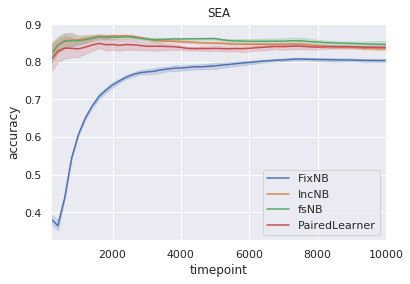

BaselineNB RTG
IncNB RTG
fsNB_ks RTG


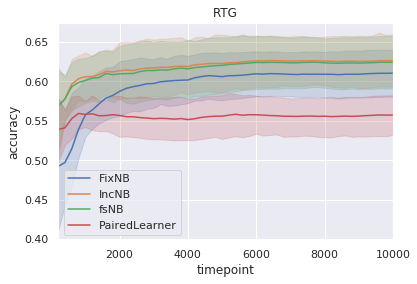

BaselineNB RBF
IncNB RBF
fsNB_ks RBF


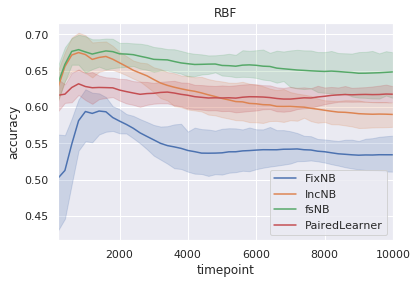

BaselineNB AGRa
IncNB AGRa
fsNB_ks AGRa


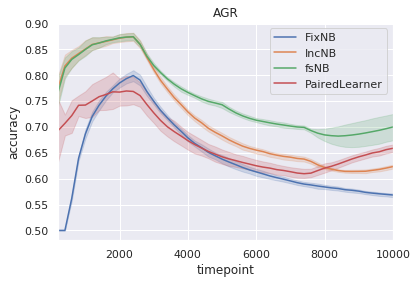

BaselineNB HYP
IncNB HYP
fsNB_ks HYP


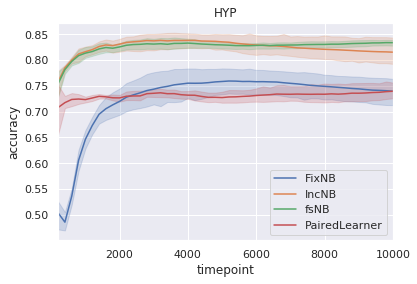

In [13]:
for dataset_name in dataset_name_list:
    for eval_func in eval_func_list:
        all_pd = None
        print(eval_func.__name__, dataset_name)
        for num_copy in range(5):
            result = np.loadtxt('IJCNN_results/' + dataset_name + '_' +
                                eval_func.__name__ + '_' + str(num_copy),
                                delimiter=',')
            correct_prediction = np.abs(result[:, 0] - result[:, 1])
            acc = 1 - np.cumsum(correct_prediction) / base

            result[:, 0] = base
            result[:, 1] = acc
            result_pd = pd.DataFrame(result[plot_skip_idx])
            result_pd.columns = ['timepoint', 'accuracy']
            #result_pd['accuracy'].plot()
            if all_pd is None:
                all_pd = result_pd
            else:
                all_pd = pd.concat([all_pd, result_pd])

        sns.lineplot(x="timepoint", y="accuracy", data=all_pd)
    sns.lineplot(x="timepoint", y="accuracy", data=pl_pd_list[dataset_name])
    plt.legend(['FixNB', 'IncNB', 'fsNB', 'PairedLearner'])
    plt.title(dataset_name.replace('a', ''))
    plt.xlim([200, 10000])
    plt.savefig(dataset_name + '.pdf')
    plt.show()